In [2]:
import os
import numpy as np
from PIL import Image
from scipy import ndimage, stats
from scipy.fft import fft, fftfreq, fftn
import skimage.io
from skimage.measure import regionprops, label, find_contours
from skimage.segmentation import flood
import matplotlib.pyplot as plt
from scipy.ndimage import shift, distance_transform_edt, rotate, map_coordinates, zoom
import tifffile as tiff
import cv2
import glob
from scipy.signal import wiener, find_peaks
from circle_fit import taubinSVD, plot_data_circle, hyperSVD, prattSVD, hyperLSQ, lm, standardLSQ
import homemade_hilo as hilo

In [3]:
save_dir = "D:/surgele/refocusing/mire_lamp_fluo"

In [4]:
file_path0=os.path.join(save_dir,'ref.tiff')  
bg_path=os.path.join(save_dir,'bg.tiff')  
# file_path=os.path.join(save_dir,'0.tiff')       
file_pathS = sorted(glob.glob(os.path.join(save_dir,'depth/*.tiff')))
# file_path_positives = sorted(glob.glob(os.path.join(save_dir,'positive/*.tiff')))
# file_path_negatives = sorted(glob.glob(os.path.join(save_dir,'negative/*.tiff')))

In [5]:
def pre_processing(angle, pitch, file_path, bg_path=None):
   LFM1 = skimage.io.imread(file_path)
   if bg_path != None:
       bg = skimage.io.imread(bg_path)
       LFM1 = (LFM1 - bg)
   img_rotated = ndimage.rotate(LFM1, angle, reshape=True) 
   LFM1 = img_rotated.astype(np.int32)
   h, w = LFM1.shape[:2]
   fraction1 = 15/pitch
   fraction2 = 15/pitch
   img_resized = np.array(Image.fromarray(LFM1, mode='I').resize((int(fraction1 * w), int(fraction2 * h)), Image.Resampling.BILINEAR))
   return img_resized


# Number of microlenses in X and Y on the raw image (140 x 140 for us)
Nx=140
Ny=140

def calibrate_LFM3(img, x, y):
    step = 15  # espacement entre microlentilles

    LFM = np.zeros((Nx, Ny, step, step))
    XX = np.zeros((Nx, Ny))
    YY = np.zeros((Nx, Ny))
    CenterX = np.zeros((Nx, Ny))
    CenterY = np.zeros((Nx, Ny))
    CenterX_ini = np.zeros((Nx, Ny))
    CenterY_ini = np.zeros((Nx, Ny))

    for ii in range(Nx):
        for jj in range(Ny):

            if ii == 0 and jj == 0:
                cx, cy = x, y
            elif ii == 0:
                # première ligne : moyenne impossible, on prend celle de gauche
                cx = CenterX[ii, jj - 1] + step
                cy = CenterY[ii, jj - 1]
            elif jj == 0:
                # premiere colonne : moyenne impossible, se base sur la lentille au-dessus
                cx = CenterX[ii - 1, jj]
                cy = CenterY[ii - 1, jj] + step
            else:
                # moyenne entre la lentille de gauche et celle du dessus
                cx = (CenterX[ii - 1, jj] + CenterX[ii, jj - 1] + step) / 2
                cy = (CenterY[ii - 1, jj] + CenterY[ii, jj - 1] + step) / 2

            # ancienne methode (voir en bas)
            # if ii==0 and jj==0:
            #     CenterX[ii,jj]=x0
            #     CenterY[ii,jj]=y0
            # elif ii==0 and jj!=0:
            #     CenterX[ii,jj]=CenterX[ii,jj-1]+15
            #     CenterY[ii,jj]=CenterY[ii,jj-1]
            # elif ii!=0 and jj==0:
            #     CenterX[ii,jj]=CenterX[ii-1,jj]
            #     CenterY[ii,jj]=CenterY[ii-1,jj]+15
            # else:
            #     CenterX[ii,jj]=CenterX[ii,jj-1]+15
            #     CenterY[ii,jj]=CenterY[ii,jj-1]

            cx = int(cx)
            cy = int(cy)

            # extraction de la microlentille dans l'image
            intermediate = img[cy-(step//2):cy+(step//2 + 1), cx-(step//2):cx+(step//2 + 1)]
            intermediate = intermediate.astype(float)
            
            max_pos = np.unravel_index(np.argmax(intermediate), intermediate.shape)
            thresh = np.percentile(intermediate, 30)
            flooded = flood(intermediate, seed_point=max_pos, tolerance=intermediate[max_pos]-thresh)

            ##### Méthode centre de masse #####
            # a = ndimage.center_of_mass(flooded)
            # ymax = round(a[0])
            # xmax = round(a[1])

            # a = ndimage.center_of_mass(flooded)
            # ymax = round(a[0])
            # xmax = round(a[1])

            ##### Autre méthode géométrique #####
            # (center_y,center_x) = get_max_distance_center2(flooded)
            # ymax = round(center_y)
            # xmax = round(center_x)

            ##### Contours + Circle-fit #####
            flooded = flooded.astype(np.uint8)
            contours, _ = cv2.findContours(flooded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            main_contour = min(contours, key=len)
            points = main_contour[:, 0, :]  # de (n,1,2) vers (n,2)
            fit = taubinSVD(points)
            ymax = round(fit[1])
            xmax = round(fit[0])

            
            # if ii==0 and jj==0:
            #     plot_data_circle(points, fit[0], fit[1], fit[2])
            #     plt.imshow(intermediate)
            #     plt.contour(flooded, colors='r')
            #     plt.plot(xmax, ymax, 'bo')  # Nouveau centre géométrique
            #     plt.title("Contours et centre")
            #     plt.show()
            
            dx = xmax - (step // 2)
            dy = ymax - (step // 2)

            XX[ii, jj] = dx
            YY[ii, jj] = dy

            # ajustement du centre
            cx_adj = cx + dx
            cy_adj = cy + dy
            CenterX_ini[ii, jj] = cx
            CenterY_ini[ii, jj] = cy
            CenterX[ii, jj] = cx_adj
            CenterY[ii, jj] = cy_adj

            # Ré-extraction de la micro-image ajustée
            LFM[ii, jj] = img[cy_adj-(step//2):cy_adj+(step//2 + 1), cx_adj-(step//2):cx_adj+(step//2 + 1)]

    return LFM, CenterX, CenterY, XX, YY, CenterX_ini, CenterY_ini


def get_max_distance_center2(flooded):
    labeled = label(flooded)
    props = regionprops(labeled)
    best_center = None
    best_score = -1
    for region in props:
        minr, minc, maxr, maxc = region.bbox
        if minr == 0 or minc == 0 or maxr == flooded.shape[0] or maxc == flooded.shape[1]:
            continue  # ignore si ca touche le bord de la sous image
        mask = (labeled == region.label)
        dist = distance_transform_edt(mask)
        max_idx = np.unravel_index(np.argmax(dist), dist.shape)
        score = dist[max_idx]
        if score > best_score:
            best_score = score
            best_center = max_idx
    return best_center if best_center is not None else (ndimage.center_of_mass(flooded))


def compute_LFM(img, CenterX, CenterY, XX, YY):
    step = 15
    LFM = np.zeros([Nx, Ny, 15, 15])
    for ii in range(0, Nx):
        for jj in range(0, Ny):    
            LFM[ii, jj, :, :] = img[int(CenterY[ii, jj])-(step//2):int(CenterY[ii, jj])+(step//2 + 1), 
                                     int(CenterX[ii, jj])-(step//2):int(CenterX[ii, jj])+(step//2 + 1)]   
    return LFM


def rendered_focus(C,rendered_height, rendered_width, side, radiance, returnVal=False):
    rendered = np.zeros((rendered_height, rendered_width))
    center_uv = int(side/2)
    for u in range(0, side):
        for v in range(0, side):
            shift_x, shift_y = C*(center_uv-u), C*(center_uv-v)
            rendered[:, :] += shift(radiance[:, :, u, v], (shift_x, shift_y))
    final = rendered / (side*side)
    if returnVal:
        return final

In [6]:
angle = -0.0001 # -0.057 pour les tests de mai
pitch = 14.02 
x0 = 16 # 1er centre à choisir en fonction de calibration_image
y0 = 13

calibration_image=pre_processing(angle, pitch, file_path0, bg_path)
LFM,centerX,centerY,CX,CY, centerX_ini, centerY_ini=calibrate_LFM3(calibration_image, x0, y0)

# bright=pre_processing(angle,pitch, file_path, bg_path)
# LFM01=compute_LFM((bright/(calibration_image+1))*np.mean(calibration_image),centerX,centerY, CX, CY)
# rendered_height,rendered_width=LFM01.shape[0],LFM01.shape[1]
# side=LFM01.shape[2]                                          
# radiance=LFM01   

# persp = radiance[:, :, 7, 7]
# tiff.imwrite(os.path.join(save_dir, 'calibration_image.tiff'), calibration_image)

In [ ]:
# radiance_posS = []
# side_posS = []
# rendered_height_posS = []
# rendered_width_posS = []
# mire_positives = []
 
# for file_path_positive in file_path_positives:
#     pos=pre_processing(angle,pitch, file_path_positive, bg_path)
#     LFM01_pos=compute_LFM((pos/(calibration_image+1))*np.mean(calibration_image),centerX,centerY,CX,CY)
#     rendered_height_pos,rendered_width_pos=LFM01_pos.shape[0],LFM01_pos.shape[1]
#     side_pos=LFM01_pos.shape[2]                                          
#     radiance_pos=LFM01_pos
#     persp = radiance_pos[:, :, 7, 7]
#     mire_positives.append(persp)
#     # Extract the filename without extension and add '_persp'
#     original_filename = os.path.basename(file_path_positive)
#     filename_wo_ext = os.path.splitext(original_filename)[0]
#     new_filename = f"persp/{filename_wo_ext}_persp.tiff"

#     # Save the output
#     # tiff.imwrite(os.path.join(save_dir, new_filename), persp)

#     stacked_perspectives_pos = np.stack([radiance_pos[:, :, i, j] for i in range(radiance_pos.shape[3]) for j in range(radiance_pos.shape[3])])
#     # tiff.imwrite(os.path.join(save_dir, f"persp/{filename_wo_ext}_perspectives.tiff"), stacked_perspectives_pos)

#     radiance_posS.append(radiance_pos)
#     side_posS.append(side_pos)
#     rendered_height_posS.append(rendered_height_pos)
#     rendered_width_posS.append(rendered_width_pos)

# radiance_negS = []
# side_negS = []
# rendered_height_negS = []
# rendered_width_negS = []
# mire_negatives = []

# for file_path_negative in file_path_negatives:
#     neg=pre_processing(angle,pitch, file_path_negative, bg_path)
#     LFM01_neg=compute_LFM((neg/(calibration_image+1))*np.mean(calibration_image),centerX,centerY,CX,CY)
#     rendered_height_neg,rendered_width_neg=LFM01_neg.shape[0],LFM01_neg.shape[1]
#     side_neg=LFM01_neg.shape[2]                                          
#     radiance_neg=LFM01_neg
#     persp_neg = radiance_neg[:, :, 7, 7]
#     mire_negatives.append(persp_neg)
#     # Extract the filename without extension and add '_persp'
#     original_filename = os.path.basename(file_path_negative)
#     filename_wo_ext = os.path.splitext(original_filename)[0]
#     new_filename = f"persp/{filename_wo_ext}_persp.tiff"

#     # Save the output
#     # tiff.imwrite(os.path.join(save_dir, new_filename), persp)

#     stacked_perspectives_neg = np.stack([radiance_neg[:, :, i, j] for i in range(radiance_neg.shape[3]) for j in range(radiance_neg.shape[3])])
#     tiff.imwrite(os.path.join(save_dir, f"persp/{filename_wo_ext}_perspectives.tiff"), stacked_perspectives_neg)
   
#     radiance_negS.append(radiance_neg)
#     side_negS.append(side_neg)
#     rendered_height_negS.append(rendered_height_neg)
#     rendered_width_negS.append(rendered_width_neg)


In [11]:
radiance_posS, radiance_negS, radianceS = [], [], []
side_posS, side_negS, sideS = [], [], []
rendered_height_posS, rendered_height_negS, rendered_heightS = [], [], []
rendered_width_posS, rendered_width_negS, rendered_widthS = [], [], []
mire_positives, mire_negatives, mireS = [], [], []
file_path_negS, file_path_posS = [], []

#################
zero_depth = 5626
#################

for file_path in file_pathS:
    img=pre_processing(angle,pitch, file_path, bg_path)
    LFM01=compute_LFM((img/(calibration_image+1))*np.mean(calibration_image),centerX,centerY,CX,CY)
    rendered_height,rendered_width=LFM01.shape[0],LFM01.shape[1]
    side=LFM01.shape[2]                                          
    radiance=LFM01
    
    # Extract the filename without extension and add '_persp'
    original_filename = os.path.basename(file_path)
    filename_wo_ext = os.path.splitext(original_filename)[0]
    new_filename = f"persp/{filename_wo_ext}_persp.tiff"

    stacked_perspectives = np.stack([radiance[:, :, i, j] for i in range(radiance.shape[3]) for j in range(radiance.shape[3])])
    # tiff.imwrite(os.path.join(save_dir, f"persp/{filename_wo_ext}_perspectives.tiff"), stacked_perspectives_pos)

    radianceS.append(radiance)
    sideS.append(side)
    rendered_heightS.append(rendered_height)
    rendered_widthS.append(rendered_width)
    
    if int(filename_wo_ext) == zero_depth: # cas z=0
        radiance_0 = radiance
        side_0 = side
        rendered_height_0 = rendered_height
        rendered_width_0 = rendered_width
    elif int(filename_wo_ext) > zero_depth: # cas defocus positif, sample se rapproche de l'objectif
        radiance_posS.append(radiance)
        side_posS.append(side)
        rendered_height_posS.append(rendered_height)
        rendered_width_posS.append(rendered_width)
        file_path_posS.append(file_path)
    elif int(filename_wo_ext) < zero_depth: # cas defocus negatif, sample s'eloigne de l'objectif
        radiance_negS.append(radiance)
        side_negS.append(side)
        rendered_height_negS.append(rendered_height)
        rendered_width_negS.append(rendered_width)
        file_path_negS.append(file_path)
    

In [ ]:
# rendered_images_pos=[]  # Array to store the volumetric image 
# C_values=np.linspace(0,5,50)   # Coefficient C that depends on the depth

# for C in (C_values):    # Apply Shift and Sum algorithm: set the depth limits and the number of slices
#     rendered_image=rendered_focus(C, rendered_height_negS[5], rendered_width_negS[5], side_negS[5], radiance_negS[5], returnVal=True)
#     rendered_images_pos.append(rendered_image)
 
# rendered_images_stack_pos=np.stack(rendered_images_pos)

# # Save z stack
# tiff.imwrite(os.path.join(save_dir,'zstack_-50.tiff'), rendered_images_stack_pos)

In [ ]:
# x = [-120,-100,-80,-60,-40,-20,0,20,40,60,80,100,120]
# y = [2.7,2.4,1.8,1.2,0.8,0,0,-0.5,-1,-1.3,-1.8,-2.7,-2.9]
# plt.figure(figsize=(8, 6))
# plt.plot(x, y, marker='o', linestyle='-', color='blue')

# ax = plt.gca()
# ax.spines['left'].set_position('zero')
# ax.spines['bottom'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# plt.xlabel("z (um)", loc='left')  
# plt.ylabel("C", loc='bottom')   
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.title("C value for each defocus position z")
# plt.show()

In [9]:
import numpy as np
from scipy.interpolate import interpn
from scipy.fft import fftshift, ifftn, ifftshift


def generate_frequency_grid(res_x, res_y):
    """
    Generate grid of frequency values for an image of size (res_x, res_y).

    Returns:
        wx, wy : 2D frequency grids
        xC, yC : Index of the zero frequency component
    """
    wx, wy = np.meshgrid(np.arange(1, res_x + 1), np.arange(1, res_y + 1))

    xC = int(np.ceil((res_x + 1) / 2)) # coordinates of the center of the frequency grid
    yC = int(np.ceil((res_y + 1) / 2))

    wx = (wx - xC) / (res_x - 1) # normalisation of the grid -> wx horizontal freq values
    wy = (yC - wy) / (res_y - 1) # same for vertical freq values

    return wx, wy, xC - 1, yC - 1  # subtract 1 for 0-based Python indexing


def refocus_fourierslice(LF_FFT, res_y, res_x, alpha, is_OS):
    ny, nx = res_y, res_x # size of the image
    even_fft = 1 - np.mod([ny, nx], 2) # 1 if dimension odd, 0 if even -> to ensure symmetric cropping

    ny_pad, nx_pad, nv_pad, nu_pad = LF_FFT.shape

    # Frequency grid
    kx, ky, kx_mid, ky_mid = generate_frequency_grid(nx_pad, ny_pad) # gives normalized freq coords for spatial (x, y) domain
    ku, kv, ku_mid, kv_mid = generate_frequency_grid(nu_pad, nv_pad) # gives normalized freq coords for angular (u, v) domain
    # kx, ky, ku and kv are 2D arrays of x, y, u or v freqs
    # .._mid are for 0 freq (center)

    # Frequency scaling
    kv_alpha = (1 - alpha) * ky # sheared(cut) angular freq indices -> shift angular coords to simul refocus
    ku_alpha = (1 - alpha) * kx

    # Compute interpolation coordinates
    dKv = np.abs(kv[1, 0] - kv[0, 0]) # spacing in v
    dKu = np.abs(ku[0, 1] - ku[0, 0]) # spacing in u
    kv_alpha_idx = kv_mid - (kv_alpha / dKv) # Converts continuous frequency shift into index space
    ku_alpha_idx = (ku_alpha / dKu) + ku_mid

    # Clamp indices to valid bounds
    kv_alpha_idx = np.clip(kv_alpha_idx, 0, nv_pad - 1)
    ku_alpha_idx = np.clip(ku_alpha_idx, 0, nu_pad - 1)

    # Create meshgrid for spatial dims
    ky_idx, kx_idx = np.meshgrid(np.arange(ny_pad), np.arange(nx_pad), indexing='ij')

    # Interpolation over 4D grid
    points = (
        np.arange(ny_pad),  # y
        np.arange(nx_pad),  # x
        np.arange(nv_pad),  # v
        np.arange(nu_pad),  # u
    )

    values = LF_FFT

    # Prepare coordinates for slicing: shape (H, W, 4)
    slice_coords = np.stack([
        ky_idx,          # y
        kx_idx,          # x
        kv_alpha_idx,    # v
        ku_alpha_idx     # u
    ], axis=-1)

    # Interpolate
    slice = interpn(points, values, slice_coords, method='linear', bounds_error=False, fill_value=0)
    slice = np.nan_to_num(slice)

    if is_OS:
        ky_idx_OS = np.linspace(0, ny_pad - 1, 2 * ny_pad)
        kx_idx_OS = np.linspace(0, nx_pad - 1, 2 * nx_pad)
        kx_OS, ky_OS = np.meshgrid(kx_idx_OS, ky_idx_OS, indexing='ij')

        # Interpolate slice to oversampled grid
        slice_OS = interpn(
            (np.arange(ny_pad), np.arange(nx_pad)),
            slice,
            np.stack([ky_OS, kx_OS], axis=-1),
            method='linear',
            bounds_error=False,
            fill_value=0
        )
        slice_OS = np.nan_to_num(slice_OS)

        temp = fftshift(ifftn(ifftshift(slice_OS)))
        ky_mid_OS = (2 * ny_pad + 1) // 2
        kx_mid_OS = (2 * nx_pad + 1) // 2

        im_refocus = np.real(temp[
            ky_mid_OS - ny // 2 : ky_mid_OS + ny // 2 - even_fft[0],
            kx_mid_OS - nx // 2 : kx_mid_OS + nx // 2 - even_fft[1]
        ])
        im_fft = np.log(np.abs(slice_OS) + 1)
        im_fft = im_fft[
            ky_mid_OS - ny // 2 : ky_mid_OS + ny // 2 - even_fft[0],
            kx_mid_OS - nx // 2 : kx_mid_OS + nx // 2 - even_fft[1]
        ]
    else:
        temp = fftshift(ifftn(ifftshift(slice))) # 2D inverse FFT on the slice to get the refocused image
        im_refocus = np.real(temp[
            ky_mid - ny // 2 : ky_mid + ny // 2 - even_fft[0], # crop to original image size
            kx_mid - nx // 2 : kx_mid + nx // 2 - even_fft[1]
        ])
        im_fft = np.log(np.abs(slice) + 1)
        im_fft = im_fft[
            ky_mid - ny // 2 : ky_mid + ny // 2 - even_fft[0],
            kx_mid - nx // 2 : kx_mid + nx // 2 - even_fft[1]
        ]

    return im_refocus, im_fft

def refocus(radianceS, file_pathS, Padding=False, OverSampling=False):
    "Performs a fourier slice refocusing and generates stacks of images and ffts"
    
    # Parameters
    res_y = 140
    res_x = 140
    res_v = 15
    res_u = res_v
    is_Padding = Padding
    is_OverSampling = OverSampling
    print(len(radianceS))

    F = 165000
    alphaS = []
    for z in np.arange(-100, 100, 10):
        d = np.abs(z/F)
        if z > 0:
            alpha = 1 + d
        else:
            alpha = 1 - d
        alphaS.append(alpha)

    for i in range(len(radianceS)):
        print(i)
        LF = radianceS[i]

        if is_Padding:
            pad_y = round(0.05 * res_y)
            pad_x = round(0.05 * res_x)
            pad_vu = 10
            pad_width = ((pad_y, pad_y), (pad_x, pad_x), (pad_vu, pad_vu), (pad_vu, pad_vu))
            LF = np.pad(LF, pad_width, mode='constant', constant_values=0)
        
        LF_FFT = fftshift(fftn(ifftshift(LF)))

        im_refocusS =[]
        im_fftS = []

        # for alpha in np.arange(min, max, step): # alpha=1 corresponds to the actual image plane, others are behind/in front
            # print(f"Refocusing at alpha = {alpha:.2f}", end='', flush=True)
            # start_time = time.time()
        for alpha in alphaS:
            im_refocus, im_fft = refocus_fourierslice(LF_FFT, res_y, res_x, alpha, is_OverSampling)

            # print(f" (done in {time.time() - start_time:.2f}s)")
            
            # Normalize and save
            # im_refocus = img_as_ubyte(rescale_intensity(im_refocus, in_range='image', out_range=(0, 1)))
            # im_fft = img_as_ubyte(rescale_intensity(im_fft, in_range='image', out_range=(0, 1)))

            im_refocusS.append(im_refocus)
            im_fftS.append(im_fft)
        
        refocus_stack = np.stack(im_refocusS)
        fft_stack = np.stack(im_fftS)
        original_filename = os.path.basename(file_pathS[i])
        filename_wo_ext = os.path.splitext(original_filename)[0]
        new_filename_refocus = f"{filename_wo_ext}_refocus_stack.tiff"
        new_filename_fft = f"{filename_wo_ext}_fft_stack.tiff"
        tiff.imwrite(os.path.join(save_dir, new_filename_refocus), refocus_stack)
        tiff.imwrite(os.path.join(save_dir,new_filename_fft), fft_stack)
        print("Stacks Saved")
              

In [ ]:
# # donner en parametres la liste des radiances pour pos ou neg et la liste des file paths pour pos ou neg
# refocus(radiance_negS, file_path_negatives, min=1, max=5, step=0.1)
refocus(radianceS, file_pathS)

In [20]:
def refocus_test(radiance, Padding=False):
    "Performs a fourier slice refocusing and generates stacks of images and ffts"
    # Parameters
    res_y = 140
    res_x = 140
    res_v = 15
    res_u = res_v
    is_Padding = Padding
    is_OverSampling=None

    LF = radiance

    alphaS = []
    zS = []
    F = 165000 # distance between the lens(tube lens) and the sensor(MLA) = focal distance of the tube lens
    dz = 5 # axial resolution
    for z in np.arange(-100, 100+dz, dz):
        d = np.abs((z*33**2)/F) # dz_image = M**2 * dz_objet avec M=33 et dz_objet=(-100, ..100)
        if z > 0:
            alpha = 1 + d
        else:
            alpha = 1 - d
        alphaS.append(alpha)
        zS.append(z)
        print('z = ', z, 'd = ', d, 'alpha = ', alpha)

    if is_Padding:
        pad_y = round(0.1 * res_y)
        pad_x = round(0.1 * res_x)
        pad_vu = 2
        pad_width = ((pad_y, pad_y), (pad_x, pad_x), (pad_vu, pad_vu), (pad_vu, pad_vu))
        LF = np.pad(LF, pad_width, mode='constant', constant_values=0)
        
    LF_FFT = fftshift(fftn(ifftshift(LF)))

    im_refocusS =[]
    im_fftS = []
    for alpha in alphaS : # np.arange(min, max, step)
        im_refocus =[]
        im_fft = []
        im_refocus, im_fft = refocus_fourierslice(LF_FFT, res_y, res_x, alpha, is_OverSampling)
        # im_refocus = cv2.normalize(im_refocus, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        im_refocusS.append(im_refocus)
        im_fftS.append(im_fft)
        
    refocus_stack = np.stack(im_refocusS)
    fft_stack = np.stack(im_fftS)
    
    # im_refocus = img_as_ubyte(rescale_intensity(im_refocus, in_range='image', out_range=(0, 1)))
    # im_fft = img_as_ubyte(rescale_intensity(im_fft, in_range='image', out_range=(0, 1)))

    return refocus_stack, fft_stack, zS

In [ ]:
ref='D:/surgele/refocusing/mire_lamp_fluo/ref.tiff'  
bg='D:/surgele/refocusing/mire_lamp_fluo/bg.tiff'
img='D:/surgele/refocusing/mire_lamp_fluo/depth/.tiff'

angle = -0.0001 
pitch = 14.02 
x0 = 16 
y0 = 20

calibration_image=pre_processing(angle, pitch, ref, bg)
LFM,centerX,centerY,CX,CY, centerX_ini, centerY_ini=calibrate_LFM3(calibration_image, x0, y0)
bright=pre_processing(angle,pitch, img, bg)
LFM01=compute_LFM((bright/(calibration_image+1))*np.mean(calibration_image),centerX,centerY, CX, CY)
rendered_height,rendered_width=LFM01.shape[0],LFM01.shape[1]
side=LFM01.shape[2]                                          
radiance=LFM01  

In [15]:
file_path_negS[3]

'D:/surgele/refocusing/mire_lamp_fluo\\depth\\5556.tiff'

D:/surgele/refocusing/mire_lamp_fluo\depth\5706.tiff
z =  -100 d =  0.66 alpha =  0.33999999999999997
z =  -95 d =  0.627 alpha =  0.373
z =  -90 d =  0.594 alpha =  0.406
z =  -85 d =  0.561 alpha =  0.43899999999999995
z =  -80 d =  0.528 alpha =  0.472
z =  -75 d =  0.495 alpha =  0.505
z =  -70 d =  0.462 alpha =  0.538
z =  -65 d =  0.429 alpha =  0.571
z =  -60 d =  0.396 alpha =  0.604
z =  -55 d =  0.363 alpha =  0.637
z =  -50 d =  0.33 alpha =  0.6699999999999999
z =  -45 d =  0.297 alpha =  0.7030000000000001
z =  -40 d =  0.264 alpha =  0.736
z =  -35 d =  0.231 alpha =  0.769
z =  -30 d =  0.198 alpha =  0.802
z =  -25 d =  0.165 alpha =  0.835
z =  -20 d =  0.132 alpha =  0.868
z =  -15 d =  0.099 alpha =  0.901
z =  -10 d =  0.066 alpha =  0.9339999999999999
z =  -5 d =  0.033 alpha =  0.967
z =  0 d =  0.0 alpha =  1.0
z =  5 d =  0.033 alpha =  1.033
z =  10 d =  0.066 alpha =  1.066
z =  15 d =  0.099 alpha =  1.099
z =  20 d =  0.132 alpha =  1.1320000000000001
z =  

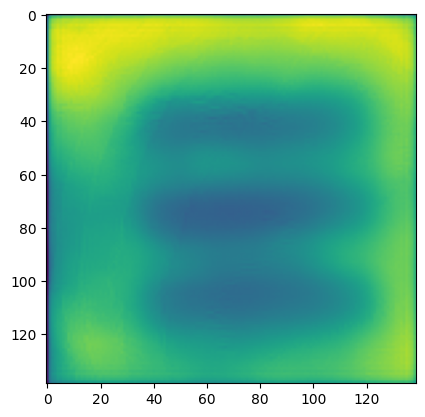

In [25]:
print(file_path_posS[7])
ig, _, _ = refocus_test(radiance_posS[7], Padding=True)
tiff.imwrite(os.path.join(save_dir,'test_+80.tiff'), ig)

plt.figure()
plt.imshow(ig[12])
plt.show()